In [1]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import shapely.ops as ops
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
%autoreload 2
from shapeshift_trajectory import shapeshift_trajectory, write_experiment

### Composing Shapes from Blocks

In [2]:
shape_1a = Shape([Block(0,0)])
shape_2a = Shape([Block(-.5,0),   Block(.5,0)])
shape_2b = Shape([Block(0,0.25),  Block(0,-0.25)])
shape_3a = Shape([Block(-.5,0),   Block(.5,0),   Block(-1.25,0.25,90)])
shape_3b = Shape([Block(-.5,0),   Block(.5,0,0), Block(-.5,0.5)])
shape_3c = Shape([Block(0,0),     Block(-1,0),   Block(1,0)])
shape_4a = Shape([Block(-.5,0),   Block(.5,0),   Block(-1.25,0.25,90),Block(1.25,0.25,90)])
shape_4b = Shape([Block(-.5,-.25),Block(-.5,.25),Block(.5,-.25),      Block(.5,.25)])
shape_6a = Shape([Block(0,0),     Block(1.,0),   Block(0,0.5),        Block(-1.,0.5),Block(1.,0.5),Block(1.,-.5)])

tests = {'line_to_L':         (shape_1a, shape_2a, (-2.5, 0.,   0.),    (-1,     .5,   0.)),  \
         'T_to_block':        (shape_1a, shape_3b, (-1.5, 0.,   0.),    (.5,     .5,   0.)),  \
         'line_to_block':     (shape_2a, shape_2a, (-2.,  0.,   0.),    (0.,     .5,   0.)),  \
         'line_to_L2':        (shape_2a, shape_2a, (-2.,  0.,   0.),    (-1.25, .75,  90.)),  \
         'U_to_block':        (shape_3a, shape_3a, (2.5,  0.,   0.),    (0.,     .5, 180.)),  \
         'line_to_block2':    (shape_4b, shape_4b, (-2.,  0.,   0.),    (0.,     1.,   0.)),  \
         'triangle_to_block': (shape_6a, shape_6a, ( 0.,-0.5, 180.),    (0.,    1.5, 180.)),  \
         'past':              (shape_1a, shape_4a, (-5.,  0.,   0.),    (5.,     0.,   0.))   \
        }

boats = {'line':ShapeBoat, 'spline':ShapeBoat_spline}

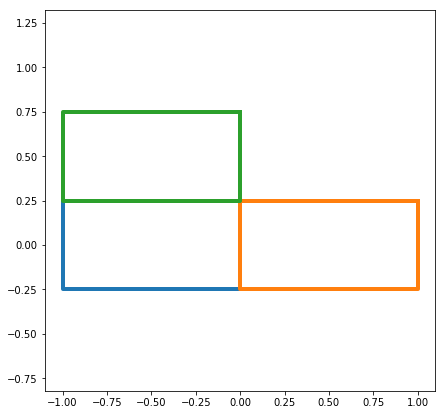

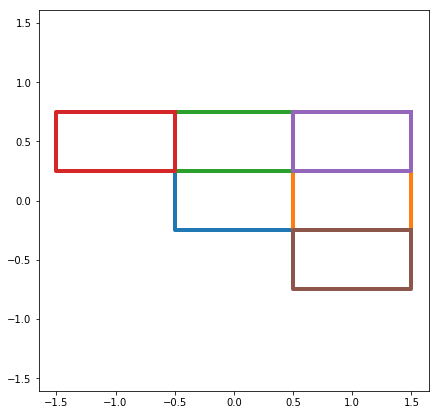

In [5]:
moving_shape=shape_3b
obstacle_shape=shape_6a

moving_shape.plot(union=False)
obstacle_shape.plot(union=False)

### Partitioning of convex hulls around shape

In [6]:
msums, hulls = obstacle_shape.c_space_rotate(moving_shape)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

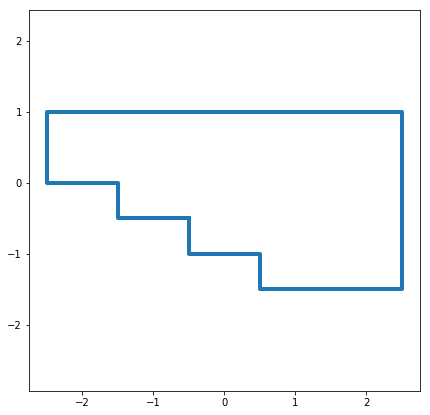

In [7]:
moving_shape.plot_polygons([msums.values()[3]])

### Finding Convex Hull of C-Space

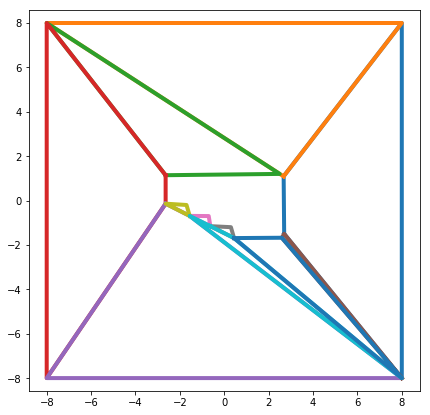

In [8]:
moving_shape.plot_polygons(hulls.values()[3])

## Trajectory Planning

### MIQP - b-splines

finding_vertex POINT (-2.5 0) 0.0
finding_vertex POINT (-1 0.5) 0.0
found path endpoint hulls 12 30
INITIALIZED ShapeBoat_spline 
boats_S:(1, 17, 6), boats_U:(1, 16, 4)
Number of decision vars 230
0.002120 seconds
ADDING COSTS
Number of costs 18
0.006634 seconds
ADDING CONSTRAINTS
Number of constraints 1146
0.137706 seconds
PLANNING
SolutionResult.kSolutionFound
0.675675 seconds



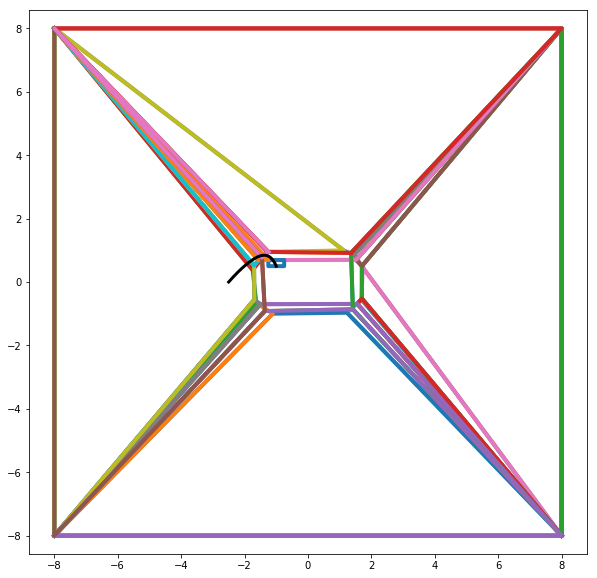

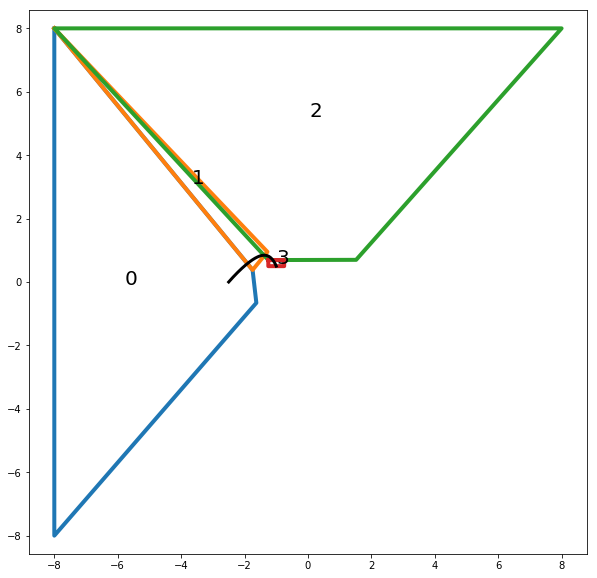

In [12]:
tests = {'line_to_L':         (shape_1a, shape_2a, (-2.5, 0.,   0.),    (-1,     .5,   0.)),  \
         'T_to_block':        (shape_1a, shape_3b, (-1.5, 0.,   0.),    (.5,     .5,   0.)),  \
         'line_to_block':     (shape_2a, shape_2a, (-2.,  0.,   0.),    (0.,     .5,   0.)),  \
         'line_to_L2':        (shape_2a, shape_2a, (-2.,  0.,   0.),    (-1.25, .75,  90.)),  \
         'U_to_block':        (shape_3a, shape_3a, (2.5,  0.,   0.),    (0.,     .5, 180.)),  \
         'line_to_block2':    (shape_4b, shape_4b, (-2.,  0.,   0.),    (0.,     1.,   0.)),  \
         'triangle_to_block': (shape_6a, shape_6a, ( 0.,-0.5, 180.),    (0.,    1.5, 180.)),  \
         'past':              (shape_1a, shape_4a, (-5.,  0.,   0.),    (5.,     0.,   0.))   \
        }

test = 'line_to_L'

experiment = shapeshift_trajectory(*tests[test], N=16)

### Show polytope graph from plan

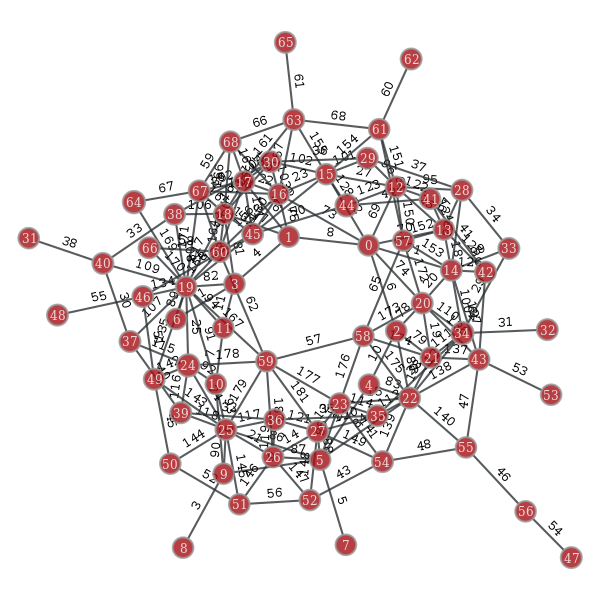

In [19]:
boat.g.draw_graph()

### Run Experiments

In [9]:
def result(test,boat):
    return shapeshift_trajectory(*tests[test],boat_type=boat, N=15)

#results = {boat:{test: result(test, boats[boat]) for test in tests} for boat in boats}